<a href="https://colab.research.google.com/github/rescobarcorrea/GEEBasinDrawer/blob/main/Basin_Drawer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Install stuff

In [ ]:
!pip install -U -q earthengine-api
!pip install -U -q folium
!pip install -U -q git+https://github.com/mccarthyryanc/folium_gee.git

!pip install geopandas
#!pip install descartes 
!pip install geemap

     |████████████████████████████████| 236 kB 5.2 MB/s 
     |████████████████████████████████| 95 kB 1.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.12.1.post1 which is incompatible.
     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 16.7 MB 38.6 MB/s 
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 42.6 MB/s 
     |████████████████████████████████| 44 kB 1.8 MB/s 
     |████████████████████████████████| 76 kB 4.6 MB/s 
     |████████████████████████████████| 5.4 MB 32.9 MB/s 
     |████████████████████████████████| 130 kB 53.6 MB/s 
     |████████████████████████████████| 1.2 MB 46.9 MB/s 
     |████████████████████████████████| 216 kB 69.7 MB/s 
     |████████████████████████████████

In [ ]:
!pip install -U -q git+https://github.com/nicolas998/WMF.git@develop

In [ ]:
!pip install -U numba
!pip install pysheds

## 2. Authenticate

In [ ]:
# Click here to authenticate
!earthengine authenticate 

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=7wO4P1nzJBI3ZQjGhAriU7DESeVUM8lEjKoZEGGFUbQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWi-k3jmyCF357uYSxx0D3eqsiLhXgD3U0aQaC82pWBumyV0Vvte8Rg

Successfully saved authorization token.


## 3. Start it up!

In [ ]:
from wmf import wmf

no cartopy
No netcdf en esta maquina, se desabilita la funcion SimuBasin.save_SimuBasin
No se logra importar basemap, por lo tanto no funciona Plot_basin
No se logra importar deap tools, por lo tanto se deshabilita SimuBasin.Calib_NSGAII
No se logra importar rasterio, se deshabilita obtencion de poligono de cuenca


In [ ]:
import ee
import folium
import foliumgee
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.distance import geodesic
from scipy.spatial.distance import cdist
from geopy.distance import distance as geodist # avoid naming confusion
import subprocess
import os
import numpy as np
from pprint import pprint
from google.colab import files
#from datetime import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date
import time
from dateutil.parser import parse
try:
        import geemap
except ImportError:
        print('geemap package not installed. Installing ...')
        subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
        import google.colab
        import geemap.eefolium as emap
except:
        import geemap as emap


from google.colab import drive
drive.mount('/content/drive')  

try:
  ee.Initialize()
  print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
  print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Earth Engine has initialized successfully!


In [ ]:
#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

# Reading raster files

## Read DEM from GEE

In [ ]:
### Elevation 5m
DEM5=ee.Image("AU/GA/DEM_1SEC/v10/DEM-H").select('elevation')
# DEM 10scs of arc
DEM10s=ee.Image("AU/GA/DEM_1SEC/v10/DEM-H").select('elevation')
australia = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(ee.Filter.eq('country_na',"Australia"))

## Read DIR map from GEE

In [ ]:
DIR3s=ee.Image("WWF/HydroSHEDS/03DIR")

## Or: create DIR map from DEM by using pysehds module

In [ ]:
# improvement, select region to extract from drawn polygon on folium

In [ ]:
#Export TIFF to drive
# Create a geometry representing an export region.
geometry = ee.Geometry.Rectangle([151.30407163395026, -33.382744750055764, 151.32638761295416, -33.36224477350021])
center = geometry.centroid().getInfo()['coordinates']
center.reverse()

# Export the image, specifying scale and region.
task = ee.batch.Export.image.toDrive(**{
    'image': DEM5,
    'description': 'imageToDriveExample',
    'folder':'Example_folder',
    'fileFormat': 'GeoTIFF',
    'region': geometry
})
task.start()

import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(5)
# read TIFF and then run dir map



Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id: UCT6TNI4UQ36JQP3OZEUYNEY).
Polling for task (id

In [ ]:
import pysheds as psh


In [ ]:
from pysheds.grid import Grid

In [ ]:
#Read TIFF from drive
input_folder ="/content/drive/My Drive/Example_folder/"
output_folder= "/content/drive/My Drive/Example_folder/"


grid = Grid.from_raster(input_folder+'imageToDriveExample.tif')
dem = grid.read_raster(input_folder+'imageToDriveExample.tif')

/usr/local/lib/python3.7/dist-packages/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/usr/local/lib/python3.7/dist-packages/pysheds/io.py:142: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


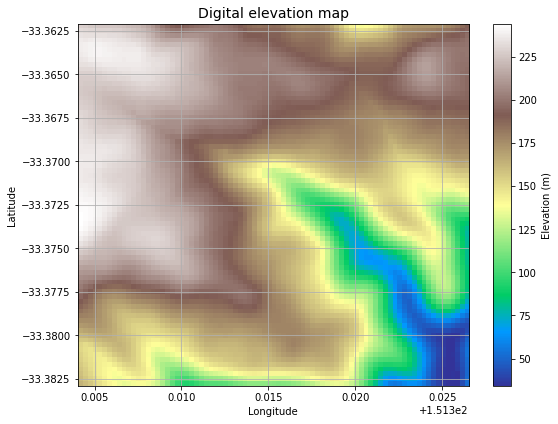

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [ ]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

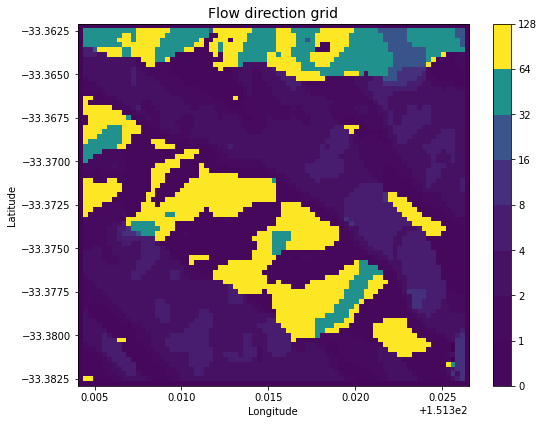

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [ ]:
acc = grid.accumulation(fdir, dirmap=dirmap)

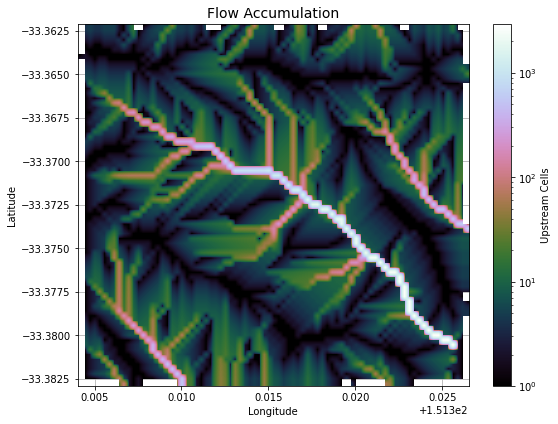

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [ ]:
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap)

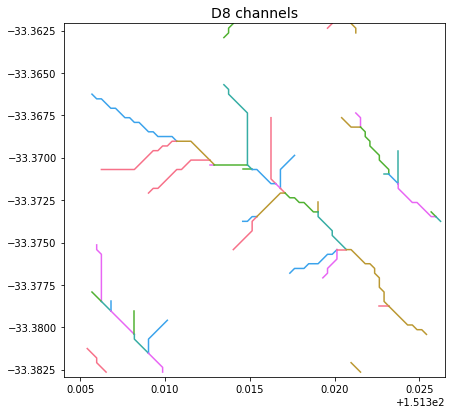

In [ ]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [ ]:
#strhaler=grid.stream_order(fdir, acc > 50, dirmap=dirmap)
strhaler=grid.stream_order(fdir,mask=acc>50,dirmap=dirmap)

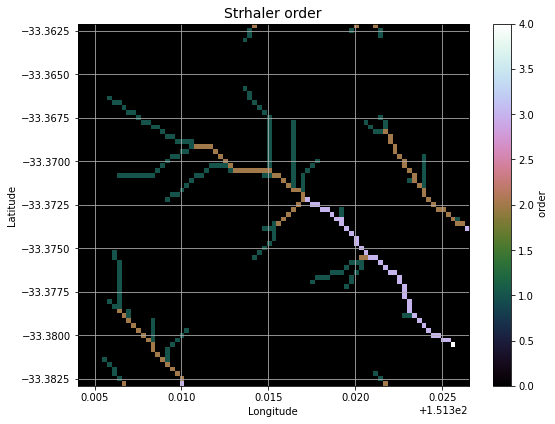

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(strhaler, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label=' order')
plt.grid(zorder=0)
plt.title('Strhaler order', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Reading river level stations

## Extract and read all the files and get coordinates

# Draw river basins corresponding to waterlevel stations

## Options 1. Use GEE dataset of rivers as streams 

## Option 2. Correct basin coordinates to the closest  cell with the highest accumulated flow within a radium R.

## Option 3. Get coordinates inputs by using Folium or a map (dreammy one)

# Run Yellow Submarine for this basins and calibrate with the water discharge